In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

0

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Fri May 10 15:09:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8              16W / 250W |   1746MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [11]:
# from imitation.util.util import make_vec_env

# observations= np.load("../dataset/obs.npy", allow_pickle=True)
# actions = np.load("../dataset/actions.npy", allow_pickle=True)

# observations=observations.squeeze()
# actions=actions.squeeze()

# print(observations.shape, actions.shape)
# print(observations[0], actions[0])
import pickle
import numpy as np
#　read /mnt/nfs/work/c98181/TDIL/saved_expert_transition/Walker2d-v3/sac/episode_num1_6123.pkl
# "states", "actions", "rewards", "next_states", "dones".
with open("/mnt/nfs/work/c98181/TDIL/saved_expert_transition/Walker2d-v3/sac/episode_num1_6123.pkl", "rb") as f:
    data = pickle.load(f)

    obs_list = data["states"]
    actions_list = data["actions"]
    observations=np.array(obs_list)
    actions=np.array(actions_list)
    # shape
    print(observations.shape)
    print(actions.shape)

# env=gym.make("Walker2d-v3",exclude_current_positions_from_observation=False,render_mode="rgb_array")
env=gym.make("Walker2d-v3",render_mode="rgb_array")


(1000, 17)
(1000, 6)


/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v3 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [13]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [16]:
policy_network = PolicyNetwork(17,6).to(device)
prev = PolicyNetwork(17,6).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)

# Training loop
num_epochs = 100
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
score_graph=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
now_log=0
now_pos=0
score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        model_act= torch.tanh( policy_network(obs_batch))
        loss= F.mse_loss(model_act,act_batch)

        optimizer.zero_grad()



        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        loss_graph.append(loss.detach().item())




        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            save_gif=True
            # test the policy and save as the first test as gif
            frames=[]
            for _ in range(num_test):
                state,_ = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action= torch.tanh(policy_network(state_tensor))
                        action.squeeze_()
                    state, reward,_, done, _ = env.step(action.cpu().numpy())  # 执行动作
                    total_reward += reward
                    if save_gif:
                        frames.append(env.render())
                save_gif=False
            image_path=f"{epoch}.gif"
            imageio.mimsave("./gif/"+image_path, frames)
            


            score=total_reward/num_test
            score_graph.append(score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "score":score})

         

env.close()

Epoch [1/100]:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.258, score=0]

Found 1 GPUs for rendering. Using device 0.


Epoch [100/100]: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it, loss=0.0631, score=1.62e+3]


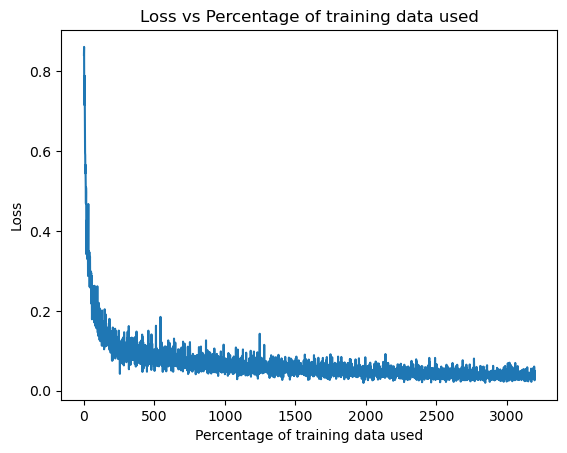

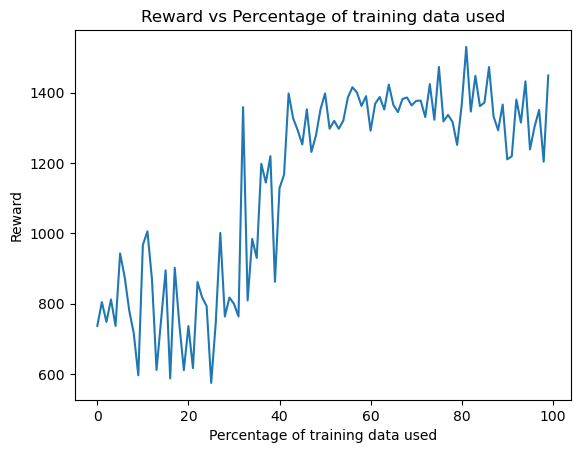

In [15]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(score_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()


